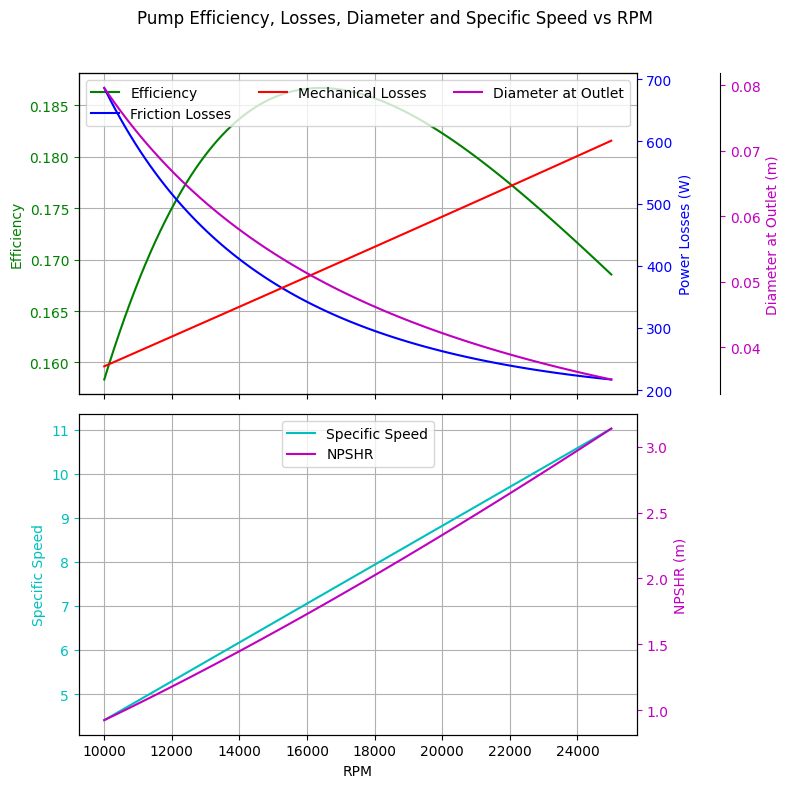

Optimum RPM: 16363.64
Required Power: 1071.31 W
Diameter at Outlet: 0.05027 m
Optimum results:
  Mass flow rate (mdot)          0.2        kg/s
  Outlet Head (H)                101.9      m
  Rotational speed (n)           1.636e+04  rpm
  Flow rate (Q)                  0.0002     m^3/s
  Specific speed (n_q)           7.214     
Outputs:
  Efficiency                     0.1867    
  Inlet Diameter (d1)            15.96      mm
  Impeller outlet diameter (d2)  50.27      mm
  Impeller inlet diameter (d1)   17.55      mm
  Power required (P)             1071       W
  Blade height (b_1)             5.266      mm
  Blade height (b_2)             2.758      mm
  Axial Clearance (s_ax)         0.5027     mm
  Radial Clearance (H)           2.5        mm
  u_1                            15.04      m/s
  u_2                            43.07      m/s
  v_3                            34.46      m/s
  v_4                            8.614      m/s
  Mechanical Loss                390.9      W
  

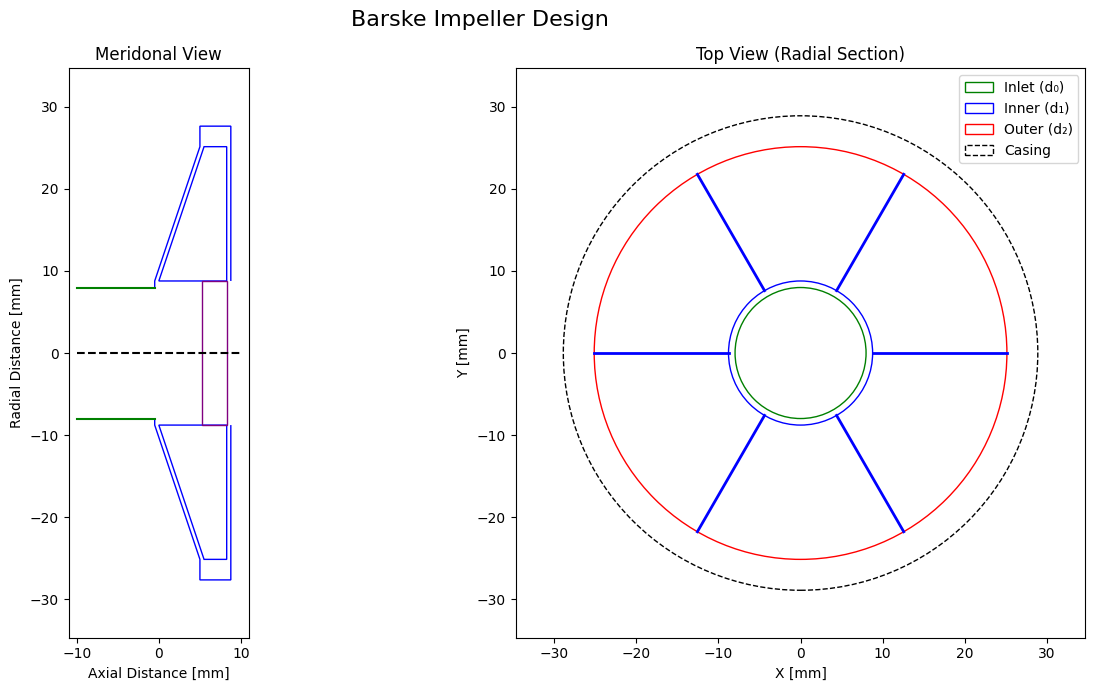

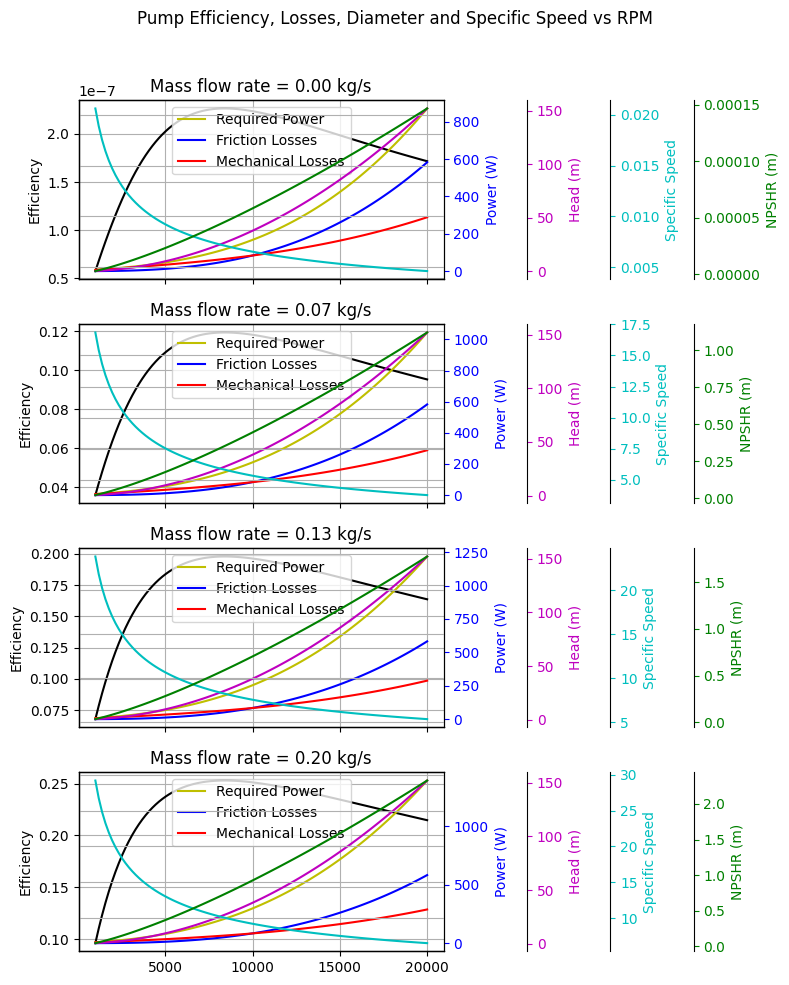

In [26]:
import numpy as np
from bearing import Bearing
from mechanicalseal import MechanicalSeal

top_bearing = Bearing(d=10.0, D=22.0, series=619, visc=1.0, C_0_kN=1.27, submerged=False)
bot_bearing = Bearing(d=10.0, D=22.0, series=619, visc=1.0, C_0_kN=1.27, submerged=True)
seal_59U19 = mechseal_59U19 = MechanicalSeal(OD_mm=28.7, ID_mm=20.9, BD_mm=19.0, F_sp=50)
seal_59U14 = mechseal_59U14 = MechanicalSeal(OD_mm=19.5, ID_mm=15, BD_mm=14, F_sp=100)


mdot_desired = 0.2
p_desired = 10 * 1e5 # 10 bars

# mdot_desired = 1.5
# p_desired = 22 * 1e5 # 10 bars

rho_0 = 1000.0  # kg/m^3
visc = 1.002e-6 # m2/s
Q_desired = mdot_desired / rho_0
v_0 = 1
d_0 = np.sqrt(4 * Q_desired / (np.pi * v_0))
d_1 = 1.1 * d_0
b_1 = 1.2 * 0.25 * d_1 
coeff_p = 0.2
g = 9.81
H_desired = p_desired / (rho_0 * g)  # m

rpms = np.linspace(10000, 25000, 100)  # RPM range for analysis
efficiencies = []
friction_losses = []
mechanical_losses = []
diameters = []
specific_speeds = []
NPSHRs = []
for n in rpms:
    d_2 = np.sqrt((1 / (1 + coeff_p)) * (7200 * p_desired / (rho_0 * n**2 * np.pi**2) + d_1**2))
    u_2 = n * np.pi * d_2 / 60
    u_1 = n * np.pi * d_1 / 60

    p_th = 0.5 * rho_0 * (2 * u_2**2 - u_1**2)
    power_friction = 1956 * rho_0 * visc**0.2 * (n/1000)**2.8 * (d_2**4.6 + 4.6 * d_1**3.6 * b_1)
    power_loss = power_friction + top_bearing.power_loss(n, 0.1, 0) + bot_bearing.power_loss(n, 0.1, 0) + seal_59U19.power_loss(n, p_desired)
    efficiency = p_desired / (p_th + (power_loss) / Q_desired)
    pressure_efficiency = p_desired / p_th

    n_q = n * Q_desired**0.5 * H_desired**-0.75
    n_s = 150 # Lower estimate from lobanoff
    NPSHR = H_desired * (n_q / n_s)**(4/3)

    efficiencies.append(efficiency)
    friction_losses.append(power_friction)
    mechanical_losses.append(power_loss - power_friction)
    diameters.append(d_2)

    specific_speeds.append(n_q)
    NPSHRs.append(NPSHR)
    
    

import matplotlib.pyplot as plt

# 2 axis

fig, (ax1, ax4) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Top subplot: Efficiency + Power losses + Diameter
ax1.plot(rpms, efficiencies, 'g-', label='Efficiency')
ax1.set_ylabel('Efficiency', color='g')
ax1.tick_params(axis='y', colors='g')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(rpms, friction_losses, 'b-', label='Friction Losses')
ax2.plot(rpms, mechanical_losses, 'r-', label='Mechanical Losses')
ax2.set_ylabel('Power Losses (W)', color='b')
ax2.tick_params(axis='y', colors='b')

ax3 = ax1.twinx()
ax3.plot(rpms, diameters, 'm-', label='Diameter at Outlet')
ax3.set_ylabel('Diameter at Outlet (m)', color='m')
ax3.tick_params(axis='y', colors='m')
ax3.spines.right.set_position(("outward", 60))

# Combine legends for top subplot
lines, labels = [], []
for a in (ax1, ax2, ax3):
    l, lab = a.get_legend_handles_labels()
    lines += l
    labels += lab
ax1.legend(lines, labels, loc='upper center', ncol=3)

# Bottom subplot: Specific speed + NPSHR
ax4.plot(rpms, specific_speeds, 'c-', label='Specific Speed')
ax4.set_xlabel('RPM')
ax4.set_ylabel('Specific Speed', color='c')
ax4.tick_params(axis='y', colors='c')
ax4.grid(True)

ax5 = ax4.twinx()
ax5.plot(rpms, NPSHRs, 'm-', label='NPSHR')
ax5.set_ylabel('NPSHR (m)', color='m')
ax5.tick_params(axis='y', colors='m')

# Combine legends for bottom subplot
lines, labels = [], []
for a in (ax4, ax5):
    l, lab = a.get_legend_handles_labels()
    lines += l
    labels += lab
ax4.legend(lines, labels, loc='upper center')

plt.suptitle('Pump Efficiency, Losses, Diameter and Specific Speed vs RPM')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

optimum_arg = np.argmax(efficiencies)
optimum_rpm = rpms[optimum_arg]
max_efficiency = efficiencies[optimum_arg]
required_power = mdot_desired * p_desired / rho_0 / max_efficiency
d_2 = np.sqrt((1 / (1 + coeff_p)) * (7200 * p_desired / (rho_0 * optimum_rpm**2 * np.pi**2) + d_1**2))
n_q = optimum_rpm * Q_desired**0.5 * H_desired**-0.75
s_ax = min(0.00075, d_2 / 100)
b_2 = max(1.5 * b_1 * d_1 / d_2, s_ax)  
B = 2 * s_ax + b_2
H = max(B / 2, 0.0025)
u_2 = optimum_rpm * np.pi * d_2 / 60
u_1 = optimum_rpm * np.pi * d_1 / 60
mechanical_loss = mechanical_losses[optimum_arg]
friction_loss = friction_losses[optimum_arg]
hydraulic_work = required_power - mechanical_loss
useful_hydraulic_work = hydraulic_work - friction_loss
static_enthalpy = mdot_desired * 0.5 * (u_2**2 - u_1**2)
theoretical_dynamic_enthalpy = mdot_desired * 0.5 * (u_2**2)
dynamic_enthalpy = mdot_desired * 0.5 * coeff_p * (u_2**2)
useful_work = mdot_desired * 0.5 * ((1 + coeff_p) * u_2**2 - u_1**2)

head_coeff = 2 * H_desired * g / u_2**2
v_3 = 0.8 * u_2  # Assuming a diffuser velocity coefficient of 0.8
d_3 = np.sqrt(Q_desired / (v_3 * np.pi)) * 2
d_4 = d_3 * 2
v_4 = v_3 / 4

blade_number = 6
w = optimum_rpm * 2 * np.pi / 60
torque = required_power / w
tip_force = torque / (d_2 / 2) / blade_number

blade_thickness = 0.0042
blade_density = 1160
blade_mass = b_2* d_2 /2 * blade_thickness * blade_density
centrifugal_force = w**2 * d_2 / 2 * blade_mass
blade_stress = centrifugal_force / (b_2 * blade_thickness)


print(f"Optimum RPM: {optimum_rpm:.2f}")
print(f"Required Power: {required_power:.2f} W")
print(f"Diameter at Outlet: {d_2:.5f} m")

print(f"Optimum results:")
print(f"  {"Mass flow rate (mdot)":<30} {mdot_desired:<10.4g} kg/s")
print(f"  {"Outlet Head (H)":<30} {H_desired:<10.4g} m")
print(f"  {"Rotational speed (n)":<30} {optimum_rpm:<10.4g} rpm")
print(f"  {"Flow rate (Q)":<30} {Q_desired:<10.4g} m^3/s")
print(f"  {"Specific speed (n_q)":<30} {n_q:<10.4g}")
print(f"Outputs:")
print(f"  {"Efficiency":<30} {max_efficiency:<10.4g}")
print(f"  {"Inlet Diameter (d1)":<30} {d_0*1000:<10.4g} mm")
print(f"  {"Impeller outlet diameter (d2)":<30} {d_2*1000:<10.4g} mm")
print(f"  {"Impeller inlet diameter (d1)":<30} {d_1*1000:<10.4g} mm")
print(f"  {"Power required (P)":<30} {required_power:<10.4g} W")
print(f"  {"Blade height (b_1)":<30} {b_1*1000:<10.4g} mm")
print(f"  {"Blade height (b_2)":<30} {b_2*1000:<10.4g} mm")
print(f"  {"Axial Clearance (s_ax)":<30} {s_ax*1000:<10.4g} mm")
print(f"  {"Radial Clearance (H)":<30} {H*1000:<10.4g} mm")
print(f"  {"u_1":<30} {u_1:<10.4g} m/s")
print(f"  {"u_2":<30} {u_2:<10.4g} m/s")
print(f"  {"v_3":<30} {v_3:<10.4g} m/s")
print(f"  {"v_4":<30} {v_4:<10.4g} m/s")
print(f"  {"Mechanical Loss":<30} {mechanical_loss:<10.4g} W")
print(f"  {"Friction Loss":<30} {friction_loss:<10.4g} W")
print(f"  {"Total Hydraulic Work":<30} {hydraulic_work:<10.4g} W")
print(f"  {"Useful Hydraulic Work":<30} {useful_hydraulic_work:<10.4g} W")
print(f"  {"Static Enthalpy":<30} {static_enthalpy:<10.4g} J/kg")
print(f"  {"Theoretical Dynamic Enthalpy":<30} {theoretical_dynamic_enthalpy:<10.4g} J/kg")
print(f"  {"Dynamic Enthalpy":<30} {dynamic_enthalpy:<10.4g} J/kg")
print(f"  {"Useful Work":<30} {useful_work:<10.4g} J/kg")
print(f"  {"Head Coefficient":<30} {head_coeff:<10.4g}")
print(f"  {"Diffuser Diameter":<30} {d_3*1000:<10.4g} mm")
print(f"  {"Diffuser Outlet Diameter":<30} {d_4*1000:<10.4g} mm")
print(f"  {"Torque":<30} {torque:<10.4g} Nm")
print(f"  {"Tip force":<30} {tip_force:<10.4g} N")
print(f"  {"Centrifugal Force":<30} {centrifugal_force:<10.4g} N")
print(f"  {"Blade Stress":<30} {blade_stress/1e6:<10.4g} MPa")



from matplotlib.patches import Polygon, Circle, Rectangle

# Create figure with two subplots - side view and top view
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Barske Impeller Design', fontsize=16)

# Side view (axial section)
ax1.set_title('Meridonal View')
ax1.set_xlabel('Axial Distance [mm]')
ax1.set_ylabel('Radial Distance [mm]')
ax1.set_aspect('equal')

# Convert to mm for plotting
rib_height = 0.003

d0_mm = d_0 * 1000
d1_mm = d_1 * 1000
d2_mm = d_2 * 1000
b1_mm = b_1 * 1000
b2_mm = b_2 * 1000
s_ax_mm = s_ax * 1000
B_mm = B * 1000
H_mm = H * 1000
rib_height_mm = rib_height * 1000


# Draw an example square
ax1.plot([-10, 10], [0, 0], color='black', linestyle='--', label='Shaft Axis')

ax1.plot([-10, -s_ax_mm], [-d0_mm/2, -d0_mm/2], color='green', linestyle='-')
ax1.plot([-10, -s_ax_mm], [d0_mm/2, d0_mm/2], color='green', linestyle='-')
# Draw top blade
ax1.add_patch(Polygon([[0, d1_mm/2], [rib_height_mm + b1_mm - b2_mm, d2_mm/2], [rib_height_mm + b1_mm, d2_mm/2], [rib_height_mm + b1_mm, d1_mm/2]], closed=True, fill=False, edgecolor='blue', linestyle='-', label='Blade (b₁)'))
# Draw bottom blade
ax1.add_patch(Polygon([[0, -d1_mm/2], [rib_height_mm + b1_mm - b2_mm, -d2_mm/2], [rib_height_mm + b1_mm, -d2_mm/2], [rib_height_mm + b1_mm, -d1_mm/2]], closed=True, fill=False, edgecolor='blue', linestyle='-', label='Blade (b₂)'))
# Draw rib
ax1.add_patch(Rectangle((b1_mm, -d1_mm/2), rib_height_mm, d1_mm, fill=False, edgecolor='purple', linestyle='-', label='Rib'))
# Draw top casing
ax1.add_patch(Polygon([[-s_ax_mm, d0_mm/2],[-s_ax_mm, d1_mm/2], [-s_ax_mm + rib_height_mm + b1_mm - b2_mm, d2_mm/2], [-s_ax_mm + rib_height_mm + b1_mm - b2_mm, d2_mm/2 + H_mm], [rib_height_mm + b1_mm + s_ax_mm, d2_mm/2 + H_mm], [rib_height_mm + s_ax_mm + b1_mm, d1_mm/2]], closed=False, fill=False, edgecolor='blue', linestyle='-', label='Blade (b₁)'))
# Draw bottom casing
ax1.add_patch(Polygon([[-s_ax_mm, -d0_mm/2],[-s_ax_mm, -d1_mm/2], [-s_ax_mm + rib_height_mm + b1_mm - b2_mm, -d2_mm/2], [-s_ax_mm + rib_height_mm + b1_mm - b2_mm, -d2_mm/2 - H_mm], [rib_height_mm + b1_mm + s_ax_mm, -d2_mm/2 - H_mm], [rib_height_mm + s_ax_mm + b1_mm, -d1_mm/2]], closed=False, fill=False, edgecolor='blue', linestyle='-', label='Blade (b₂)'))


# Top view (radial section)
ax2.set_title('Top View (Radial Section)')
ax2.set_xlabel('X [mm]')
ax2.set_ylabel('Y [mm]')
ax2.set_aspect('equal')

# Draw inlet, impeller and casing in top view
ax2.add_patch(Circle((0, 0), d0_mm/2, fill=False, color='green', linestyle='-', label='Inlet (d₀)'))
ax2.add_patch(Circle((0, 0), d1_mm/2, fill=False, color='blue', linestyle='-', label='Inner (d₁)'))
ax2.add_patch(Circle((0, 0), d2_mm/2, fill=False, color='red', linestyle='-', label='Outer (d₂)'))
ax2.add_patch(Circle((0, 0), d2_mm/2 + B_mm, fill=False, color='black', linestyle='--', label='Casing'))

# Draw simplified blades (6 blades as typical for Barske design)
blade_angles = np.linspace(0, 2*np.pi, 7)[:-1]  # 6 equally spaced angles
for angle in blade_angles:
    x1 = d1_mm/2 * np.cos(angle)
    y1 = d1_mm/2 * np.sin(angle)
    x2 = d2_mm/2 * np.cos(angle)
    y2 = d2_mm/2 * np.sin(angle)
    ax2.plot([x1, x2], [y1, y2], 'b-', linewidth=2)

# Set axis limits with some padding
max_dim = (d2_mm/2 + B_mm) * 1.2
ax2.set_xlim(-max_dim, max_dim)
ax2.set_ylim(-max_dim, max_dim)
ax1.set_ylim(-max_dim, max_dim)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

rpms = np.linspace(1000, 20000, 100)
fig, ax = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
Qs = np.linspace(1e-10, Q_desired, 4)
for i, Q in enumerate(Qs):
    mdot = Q * rho_0
    ax1 = ax[i]
    efficiencies = []
    heads = []
    friction_losses = []
    mechanical_losses = []
    specific_speeds = []
    NPSHRs = []
    required_powers = []
    for n in rpms:
        u_2 = n * np.pi * d_2 / 60
        u_1 = n * np.pi * d_1 / 60

        p_th = 0.5 * rho_0 * (2 * u_2**2 - u_1**2)
        p = 0.5 * rho_0 * ((1 + coeff_p) * u_2**2 - u_1**2)
        h = p / (rho_0 * g)
        power_friction = 1956 * rho_0 * visc**0.2 * (n/1000)**2.8 * (d_2**4.6 + 4.6 * d_1**3.6 * b_1)
        power_loss = power_friction + top_bearing.power_loss(n, 0.1, 0) + bot_bearing.power_loss(n, 0.1, 0) + seal_59U14.power_loss(n, p)
        efficiency = p / (p_th + (power_loss) / Q)
        pressure_efficiency = p_desired / p_th

        n_q = n * Q**0.5 * h**-0.75
        n_s = 150 # Lower estimate from lobanoff
        NPSHR = h * (n_q / n_s)**(4/3)

        required_power =  mdot * p / rho_0 / efficiency
        efficiencies.append(efficiency)
        heads.append(h)
        friction_losses.append(power_friction)
        mechanical_losses.append(power_loss - power_friction)
        specific_speeds.append(n_q)
        NPSHRs.append(NPSHR)
        required_powers.append(required_power)

    ax1.set_title(f"Mass flow rate = {Q*rho_0:.2f} kg/s")

    # Efficiency + Power  + NPSH + Specific Speed
    ax1.plot(rpms, efficiencies, 'k-', label='Efficiency')
    ax1.set_ylabel('Efficiency', color='k')
    ax1.tick_params(axis='y', colors='k')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(rpms, required_powers, 'y-', label='Required Power')
    ax2.plot(rpms, friction_losses, 'b-', label='Friction Losses')
    ax2.plot(rpms, mechanical_losses, 'r-', label='Mechanical Losses')
    ax2.set_ylabel('Power (W)', color='b')
    ax2.tick_params(axis='y', colors='b')

    ax3 = ax1.twinx()
    ax3.plot(rpms, heads, 'm-', label='Head')
    ax3.set_ylabel('Head (m)', color='m')
    ax3.tick_params(axis='y', colors='m')
    ax3.spines.right.set_position(("outward", 60))

    ax4 = ax1.twinx()
    ax4.plot(rpms, specific_speeds, 'c-', label='Specific Speed')
    ax4.set_xlabel('RPM')
    ax4.set_ylabel('Specific Speed', color='c')
    ax4.tick_params(axis='y', colors='c')
    ax4.grid(True)

    ax4.spines.right.set_position(("outward", 120))

    ax5 = ax1.twinx()
    ax5.plot(rpms, NPSHRs, 'g-', label='NPSHR')
    ax5.set_ylabel('NPSHR (m)', color='g')
    ax5.tick_params(axis='y', colors='g')
    ax5.spines.right.set_position(("outward", 180))

    # Combine legends for top subplot
    lines, labels = [], []
    # for a in (ax1, ax2, ax3, ax4, ax5):
    a = ax2
    l, lab = a.get_legend_handles_labels()
    lines += l
    labels += lab
    ax1.legend(lines, labels, loc='upper center')#, ncol=3)

    # # Combine legends for bottom subplot
    # lines, labels = [], []
    # for a in (ax4, ax5):
    #     l, lab = a.get_legend_handles_labels()
    #     lines += l
    #     labels += lab
    # ax4.legend(lines, labels, loc='upper center')

plt.suptitle('Pump Efficiency, Losses, Diameter and Specific Speed vs RPM')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
